In [0]:
import time
import itertools
import numpy.random as npr
import numpy as nnp
from tqdm.auto import trange

import jax.numpy as np
from jax.config import config
from jax import jit, grad, random, lax
from jax.experimental import optimizers
from jax.experimental import stax
from jax.experimental.stax import Dense, Relu, LogSoftmax, Sigmoid, FanOut, Softplus
from jax.scipy.stats import norm

import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

# Generate synthetic data

z shape:  (1000, 1)
x shape:  (1000, 2)


(-3.872985576734914, 64.14353084939629)

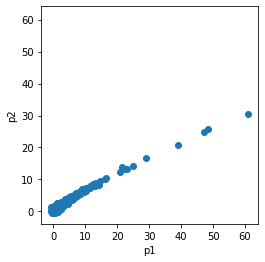

In [0]:
DIM_N = 1000    # Number of samples
DIM_D = 1       # Number of latent variables
DIM_P = 2       # Number of observations/factors
A = np.array([1.2, 1]).T
v = 0.1 * nnp.ones(DIM_P)


# Sample z_n from prior distribution
z = npr.multivariate_normal(nnp.zeros(DIM_D), nnp.eye(DIM_D), size=DIM_N)
print('z shape: ', z.shape)

# Sample x_n given z_n
x = nnp.empty((DIM_N, DIM_P))
for n in range(DIM_N):
    x[n] = npr.multivariate_normal(nnp.exp(A*z[n]), nnp.diag(v))
print('x shape: ', x.shape)

# Plot synthetic data
plt.scatter(x[:,0], x[:,1])
plt.xlabel('p1'); plt.ylabel('p2')

# Set equal axis limits
ax = plt.gca()
ax.set_aspect('equal')

xlim = plt.xlim(); ylim = plt.ylim()
start_lim = nnp.min([xlim[0], ylim[0]])
end_lim = nnp.max([xlim[1], ylim[1]])

plt.xlim([start_lim, end_lim])
plt.ylim([start_lim, end_lim])


In [0]:
# y_categorical = mnist.target.astype(int)
# label_binarizer = LabelBinarizer()
# label_binarizer.fit(range(max(y_categorical)+1))
# X = mnist.data/np.max(mnist.data)
# y = label_binarizer.transform(y_categorical)

#X_train, X_test, _, _ = train_test_split(x, y, test_size=0.25, random_state=42)
X_train = x

# Define model

For our encoder, we'll use a neural network to parameterize a Gaussian (with diagonal covariance):

\begin{aligned}(\boldsymbol{\mu}, \boldsymbol{\sigma}^2) &=\text { EncoderNeuralNet}_{\phi}(\mathbf{x}) \\ q_{\phi}(\mathbf{z} | \mathbf{x}) &=\mathcal{N}(\mathbf{z} ; \boldsymbol{\mu}, \operatorname{diag}(\boldsymbol{\sigma^2})) \end{aligned}.

To ensure that our network outputs valid covariances, we'll use a nonlinearity on the last layer that only outputs positive values: SoftPlus. Additionally, we'll share the weights of the encoder network between the $\mu$ and $\sigma^2$ network (up until the last layer).

For our decoder, we'll also use a neural network that outputs the means of the distribution of x:

\begin{aligned} p(\mathbf{z}) &=\mathcal{N}(\mathbf{z} ; 0, \mathbf{I}) \\ \mathbf{p} &=\text { DecoderNeural Net }_{\boldsymbol{\theta}}(\mathbf{z}) \\
p(\mathbf{x_n} | \mathbf{z_n}) &= \prod_{p=1}^{P} \mathcal{N}(x_{np} | e^{a_p z_n}, v_p)
\end{aligned}

In the cell below, define the encoder and decoder networks described above.

In [0]:
d_latent = DIM_D # Z.shape[1]
d_hidden = 512
d_obs = DIM_P # X.shape[1]

### YOUR CODE HERE ###
encoder_init, encoder = stax.serial(Dense(d_hidden), Relu, 
                                    Dense(d_hidden), Relu, 
                                    FanOut(2),
                                    stax.parallel(Dense(d_latent), 
                                                  stax.serial(Dense(d_latent), Softplus)))

decoder_init, decoder = stax.serial(Dense(d_hidden), Relu, 
                                    Dense(d_hidden), Relu, 
                                    FanOut(2),
                                    stax.parallel(Dense(d_obs), 
                                                  stax.serial(Dense(d_obs), Softplus)))

# Evidence lower bound

In [0]:
@jit
def elbo(elbo_rng, params, batch):
    enc_params, dec_params = params
    # sample noise from normal distribution
    epsilon = random.normal(elbo_rng, shape=(batch.shape[0], d_latent,))
    
    ## YOUR CODE HERE ##
    
    # get mu, sigmasq output from encoder net using batch as input
    mu, sigmasq = encoder(enc_params, batch)
    
    # calculate z from mu, sigmasq, and epsilon
    z = mu + np.sqrt(sigmasq)*epsilon
    
    print('mu shape', mu.shape, 'sigmasq shape', sigmasq.shape)
    # calculate log_q epsilon, and sigmasq. 
    # hint: use norm.logpdf(epsilon) to calculate the log pdf of gaussian (from jax.scipy.stats)
    log_q = np.sum(norm.logpdf(z, mu, np.sqrt(sigmasq)), axis=1)
    
    # get p from decoder using z as input
    m, ssq = decoder(dec_params, z)
    
    print('z shape', z.shape, 'm shape', m.shape, 'ssq shape', ssq.shape)
    # calculate (log) normal likelihood
    # and the (log) standard normal prior
    log_p = np.sum(norm.logpdf(z), axis=1)
    log_p += np.sum(norm.logpdf(batch, m, np.sqrt(ssq)),axis=-1)
    
    ## END YOUR CODE ##
    print(iter_idx)
    arr_encoder['m'][iter_idx] = mu
    arr_encoder['s'][iter_idx] = sigmasq
    arr_decoder['m'][iter_idx] = m
    arr_decoder['s'][iter_idx] = ssq
    elbo = np.mean(log_p - log_q)
    return elbo

# define optimizer

In [0]:
momentum_mass = 0.9
step_size = 0.001
opt_init, opt_update, get_params = optimizers.momentum(step_size, mass=momentum_mass)

In [0]:
## this is the loop that will be called on each batch of data

@jit
def update(rng, i, opt_state, batch):
    elbo_rng, data_rng = random.split(random.fold_in(rng, i))
    params = get_params(opt_state)
    #binarized_batch = random.bernoulli(data_rng, batch)

    loss = lambda params: -elbo(elbo_rng, params, batch)
    g = grad(loss)(params)

    return opt_update(i, g, opt_state)

# Initialize networks

In [0]:
enc_init_rng, dec_init_rng = random.split(random.PRNGKey(2))

_, init_encoder_params = encoder_init(enc_init_rng, (-1, d_obs))
_, init_decoder_params = decoder_init(dec_init_rng, (-1, d_latent))
init_params = init_encoder_params, init_decoder_params
opt_state = opt_init(init_params)
itercount = itertools.count()

print("\nStarting training...")


Starting training...


In [0]:
num_epochs = 100
batch_size = 128

num_train = X_train.shape[0]
num_complete_batches, leftover = divmod(num_train, batch_size)
num_batches = num_complete_batches + bool(leftover)

def data_stream():
    rng = npr.RandomState(0)
    while True:
        perm = rng.permutation(num_train)
        for i in range(num_batches):
            batch_idx = perm[i * batch_size:(i + 1) * batch_size]
            yield X_train[batch_idx]
batches = data_stream()

In [0]:
test_rng = random.PRNGKey(0)
pbar = trange(num_epochs)
arr_elbo = nnp.empty(len(pbar))
arr_encoder = {'m': nnp.empty((len(pbar), DIM_N, DIM_P)),
               's': nnp.empty((len(pbar), DIM_N, DIM_P))}
arr_decoder = {'m': nnp.empty((len(pbar), DIM_N, DIM_P)),
               's': nnp.empty((len(pbar), DIM_N, DIM_P))}
iter_idx = 0

for epoch in pbar:
    start_time = time.time()
    epoch_rng = random.PRNGKey(epoch)
    for _ in range(num_batches):
        batch = next(batches)
        opt_state = update(epoch_rng, next(itercount), opt_state, x)
        params = get_params(opt_state)
    elbo_rng, data_rng = random.split(test_rng)
    arr_elbo[iter_idx] = elbo(elbo_rng, get_params(opt_state), x)
    pbar.set_description("ELBO: {:.1f}".format(arr_elbo[iter_idx]))
    epoch_time = time.time() - start_time
    
    iter_idx += 1

    params = get_params(opt_state)


mu shape (1000, 1) sigmasq shape (1000, 1)
z shape (1000, 1) m shape (1000, 2) ssq shape (1000, 2)
0


Exception: ignored

# Plot results

Text(0, 0.5, 'ELBO')

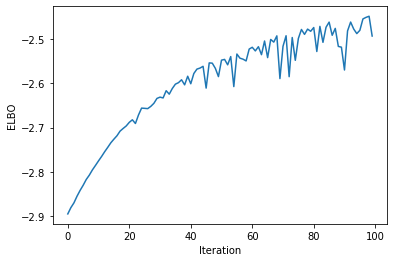

In [0]:
# Plot ELBO as function of SGD iteration
plt.plot(nnp.arange(arr_elbo.shape[0]), arr_elbo)
plt.xlabel('Iteration'); plt.ylabel('ELBO')

In [0]:
# Plot model params A1, A2, v1, v2 as function of SGD iteration
# m1 = exp^(A1 z_n) -> A1 = np.log(m1) / z_n
m.shape

NameError: ignored

# Test the model

Text(0, 0.5, 'reconstructed')

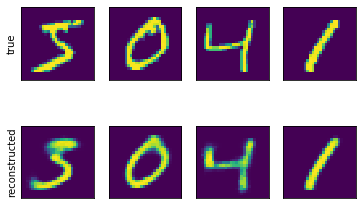

In [0]:
# Plot a few reconstructions of images
def reconstruct(X, params):
    enc_params, dec_params = params
    z, _ = encoder(enc_params, X)
    return decoder(dec_params, z)
    
fig, axs = plt.subplots(2, 4)
for i in range(4):
    axs[0, i].imshow(X[i].reshape((28, 28)))
    axs[1, i].imshow(reconstruct(X[i], params).reshape((28, 28)))
    
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])

axs[0, 0].set_ylabel("true")
axs[1, 0].set_ylabel("reconstructed")

In [0]:
# Run PCA on the embeddings to get dimensions of maximal variance
from sklearn.decomposition import PCA
Z = encoder(params[0], X[:10000])[0]
pca = PCA(2).fit(Z)

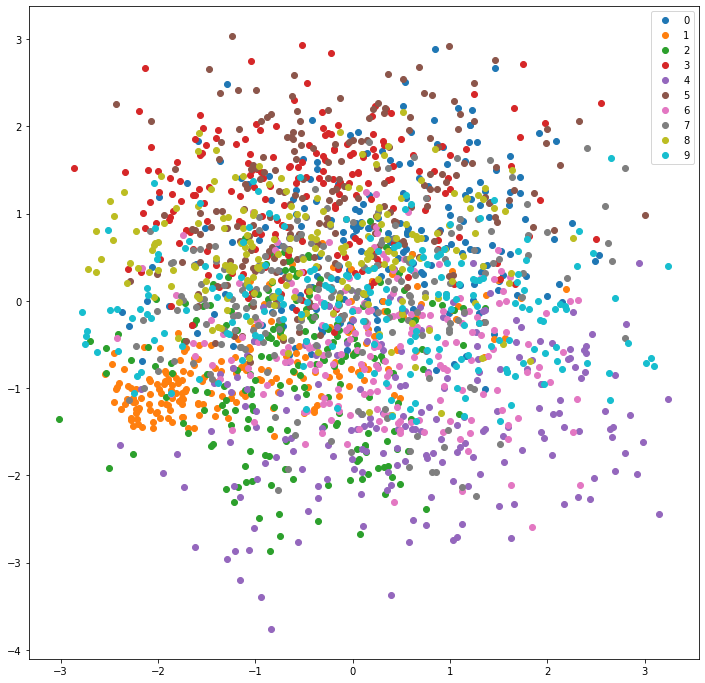

In [0]:
# Plot the embeddings for various digit classes
plt.figure(figsize=(12, 12))
for i in range(10):
    inds = np.where(y_categorical == i)[0][:200]
    z = pca.transform(encoder(params[0], X[inds])[0])
    plt.plot(z[:, 0], z[:, 1], 'o', label="{:d}".format(i))

plt.legend()

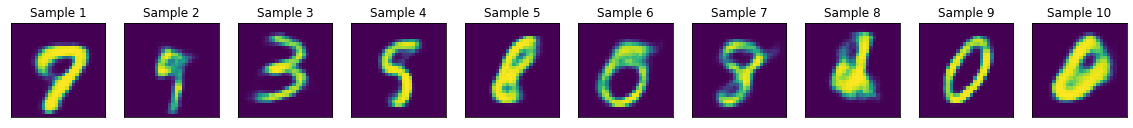

In [0]:
# Decode random Gaussian samples
# Plot a few reconstructions of images    
fig, axs = plt.subplots(1, 10, figsize=(20, 5))
for i in range(10):
    axs[i].imshow(decoder(params[1], npr.randn(10)).reshape((28, 28)))
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_title("Sample {}".format(i+1))


plt.imshow(decoder(params[1], npr.randn(10)).reshape((28, 28)))

In [0]:
# Pset 3 Q1c
# Plot the contour lines of the minimizing q's for parts (a) and (b) for the specific parameters given below

mu = np.array([0,0]).T
Sigma = np.array([[1, 0.9], [1, 0.9]])

print(mu)
print(Sigma)